In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")

✓ All libraries imported successfully!
pandas version: 2.2.2
numpy version: 2.0.2


In [2]:
df = pd.read_csv('cleaned_weather_final.csv')

In [3]:
print("data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nColumns available: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

data loaded successfully!
Dataset shape: (94247, 9)

Columns available: ['datetime', 'year', 'month', 'day', 'hour', 'temp', 'rhum', 'prcp', 'wdir']

First few rows:
              datetime  year  month  day  hour  temp  rhum  prcp  wdir
0  2015-01-01 01:00:00  2015      1    1     1   0.6    69   0.0   0.0
1  2015-01-01 02:00:00  2015      1    1     2   0.0    72   0.0   0.0
2  2015-01-01 03:00:00  2015      1    1     3  -1.7    78   0.0   0.0
3  2015-01-01 04:00:00  2015      1    1     4  -1.7    78   0.0   0.0
4  2015-01-01 05:00:00  2015      1    1     5  -2.2    81   0.0   0.0


DATA EXPLORATION

Data types:
datetime     object
year          int64
month         int64
day           int64
hour          int64
temp        float64
rhum          int64
prcp        float64
wdir        float64
dtype: object

Missing values:
datetime    0
year        0
month       0
day         0
hour        0
temp        0
rhum        0
prcp        0
wdir        0
dtype: int64

Basic statistics:
               year         month           day          hour          temp  \
count  94247.000000  94247.000000  94247.000000  94247.000000  94247.000000   
mean    2019.884283      6.418719     15.724129     11.500111     16.944636   
std        3.104764      3.417101      8.801203      6.922176      9.172033   
min     2015.000000      1.000000      1.000000      0.000000     -3.900000   
25%     2017.000000      3.000000      8.000000      6.000000     10.000000   
50%     2020.000000      6.000000     16.000000     12.000000     18.300000   
75%     2023.000000      9.000000     23.000000 

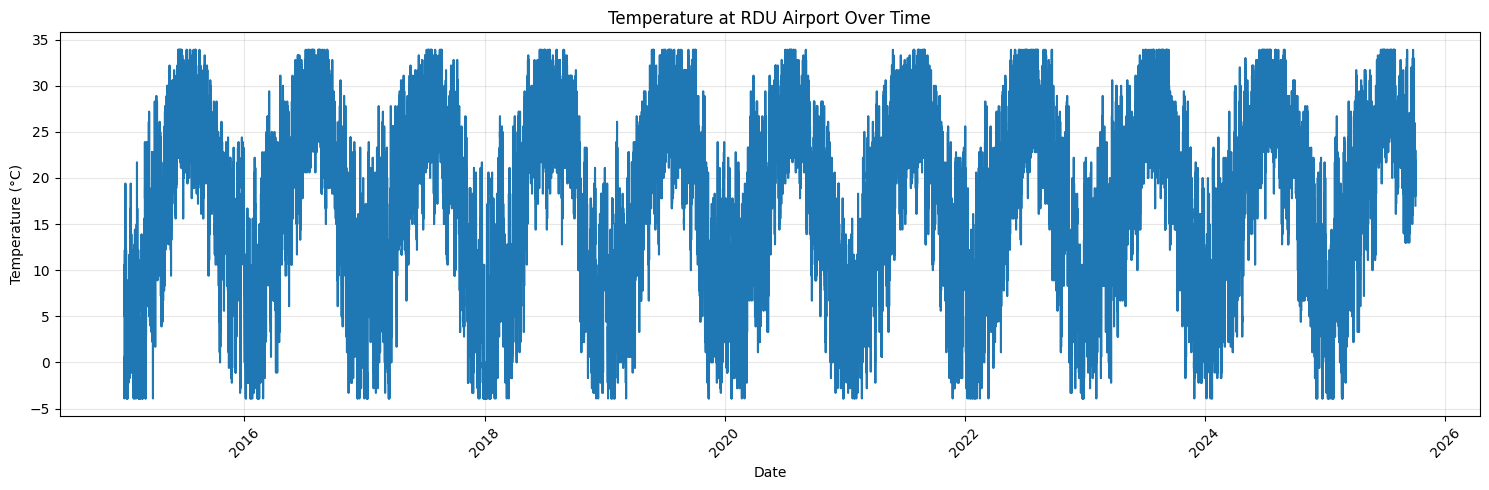

In [4]:
#EDA

print("DATA EXPLORATION")

# Check data types
print("\nData types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

# Visualize temperature over time
plt.figure(figsize=(15, 5))
if 'datetime' in df.columns:
    plt.plot(pd.to_datetime(df['datetime']), df['temperature'] if 'temperature' in df.columns else df['temp'])
else:
    plt.plot(df['temperature'] if 'temperature' in df.columns else df['temp'])
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature at RDU Airport Over Time')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
#Feature Engineering

print("FEATURE ENGINEERING")


# Make a copy to work with
df_features = df.copy()

# Ensure datetime is in proper format
if 'datetime' in df_features.columns:
    df_features['datetime'] = pd.to_datetime(df_features['datetime'])
else:
    # Create datetime from date and hour columns if needed
    print("Creating datetime column...")
    # Adjust this based on your actual column names

# Standardize column names (adjust based on your actual data)
temp_col = 'temperature' if 'temperature' in df_features.columns else 'temp'

# Extract time-based features
if 'datetime' in df_features.columns:
    df_features['hour'] = df_features['datetime'].dt.hour
    df_features['day_of_year'] = df_features['datetime'].dt.dayofyear
    df_features['month'] = df_features['datetime'].dt.month
    df_features['day_of_week'] = df_features['datetime'].dt.dayofweek
    df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)

    # Cyclical encoding for time features (IMPORTANT!)
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['day_sin'] = np.sin(2 * np.pi * df_features['day_of_year'] / 365)
    df_features['day_cos'] = np.cos(2 * np.pi * df_features['day_of_year'] / 365)

    print("time based features created")

# Create lag features (past temperatures)
df_features['temp_lag_1h'] = df_features[temp_col].shift(1)
df_features['temp_lag_3h'] = df_features[temp_col].shift(3)
df_features['temp_lag_6h'] = df_features[temp_col].shift(6)
df_features['temp_lag_24h'] = df_features[temp_col].shift(24)

# Rolling statistics
df_features['temp_rolling_mean_6h'] = df_features[temp_col].rolling(window=6, min_periods=1).mean()
df_features['temp_rolling_std_6h'] = df_features[temp_col].rolling(window=6, min_periods=1).std()
df_features['temp_rolling_mean_24h'] = df_features[temp_col].rolling(window=24, min_periods=1).mean()

print("lag features created")

# Drop rows with NaN created by lag features
df_features = df_features.dropna()

print(f"\n Feature engineering complete!")
print(f"Original shape: {df.shape}")
print(f"After feature engineering: {df_features.shape}")
print(f"Total features available: {len(df_features.columns)}")


FEATURE ENGINEERING
time based features created
lag features created

 Feature engineering complete!
Original shape: (94247, 9)
After feature engineering: (94223, 23)
Total features available: 23


In [6]:
#Prepare Train/Validation Split


print("\n" + "=" * 70)
print("SPLITTING DATA")
print("=" * 70)

# Define validation period (Sept 17-30, 2025)
validation_start = '2025-09-17'
validation_end = '2025-10-01'  # Exclusive

train_df = df_features[df_features['datetime'] < validation_start]
val_df = df_features[(df_features['datetime'] >= validation_start) &
                      (df_features['datetime'] < validation_end)]

print(f"Training set: {len(train_df)} samples")
print(f"  Date range: {train_df['datetime'].min()} to {train_df['datetime'].max()}")
print(f"\nValidation set: {len(val_df)} samples")
print(f"  Date range: {val_df['datetime'].min()} to {val_df['datetime'].max()}")

# Define features to use in the model
# ADJUST THIS LIST based on what columns you have!
feature_columns = [
    'hour', 'day_of_year', 'month', 'day_of_week',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'temp_lag_1h', 'temp_lag_3h', 'temp_lag_6h', 'temp_lag_24h',
    'temp_rolling_mean_6h', 'temp_rolling_std_6h', 'temp_rolling_mean_24h'
]

# Add weather features if available
if 'pressure' in df_features.columns:
    feature_columns.append('pressure')
if 'windspeed' in df_features.columns:
    feature_columns.append('windspeed')
if 'humidity' in df_features.columns:
    feature_columns.append('humidity')

# Keep only features that exist
feature_columns = [col for col in feature_columns if col in df_features.columns]

print(f"\n✓ Using {len(feature_columns)} features:")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i}. {feat}")

# Create X and y
X_train = train_df[feature_columns]
y_train = train_df[temp_col]

X_val = val_df[feature_columns]
y_val = val_df[temp_col]

print(f"\n✓ Data split complete!")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")



SPLITTING DATA
Training set: 93862 samples
  Date range: 2015-01-02 01:00:00 to 2025-09-16 23:00:00

Validation set: 336 samples
  Date range: 2025-09-17 00:00:00 to 2025-09-30 23:00:00

✓ Using 15 features:
  1. hour
  2. day_of_year
  3. month
  4. day_of_week
  5. hour_sin
  6. hour_cos
  7. day_sin
  8. day_cos
  9. temp_lag_1h
  10. temp_lag_3h
  11. temp_lag_6h
  12. temp_lag_24h
  13. temp_rolling_mean_6h
  14. temp_rolling_std_6h
  15. temp_rolling_mean_24h

✓ Data split complete!
X_train shape: (93862, 15)
X_val shape: (336, 15)


In [7]:
#Train Linear Regression Model


print("TRAINING LINEAR REGRESSION MODEL")


# Create and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Model trained successfully!")
print(f"\nModel intercept: {lr_model.intercept_:.3f}")
print(f"\nTop 5 Feature Coefficients (by absolute value):")

# Get feature importance
coef_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(coef_df.head(10).to_string(index=False))

TRAINING LINEAR REGRESSION MODEL
Model trained successfully!

Model intercept: 0.260

Top 5 Feature Coefficients (by absolute value):
              Feature  Coefficient
 temp_rolling_mean_6h     1.809641
          temp_lag_3h    -0.974953
             hour_sin    -0.425371
          temp_lag_1h     0.382356
             hour_cos    -0.332068
          temp_lag_6h    -0.299705
              day_cos    -0.127540
  temp_rolling_std_6h     0.090064
temp_rolling_mean_24h     0.081040
              day_sin    -0.039080


In [8]:
#Make Predictions


print("MAKING PREDICTIONS")


# Predict on both training and validation sets
y_pred_train = lr_model.predict(X_train)
y_pred_val = lr_model.predict(X_val)

print("- predictions generated!")
print(f"Training predictions: {len(y_pred_train)}")
print(f"Validation predictions: {len(y_pred_val)}")

# Show sample predictions
print("\nSample predictions (first 10 hours of validation period):")
sample_df = pd.DataFrame({
    'DateTime': val_df['datetime'].iloc[:10].values,
    'Actual (°C)': y_val.iloc[:10].values,
    'Predicted (°C)': y_pred_val[:10],
    'Error': y_val.iloc[:10].values - y_pred_val[:10]
})
print(sample_df.to_string(index=False))


MAKING PREDICTIONS
- predictions generated!
Training predictions: 93862
Validation predictions: 336

Sample predictions (first 10 hours of validation period):
           DateTime  Actual (°C)  Predicted (°C)     Error
2025-09-17 00:00:00         17.0       16.876302  0.123698
2025-09-17 01:00:00         17.0       16.797795  0.202205
2025-09-17 02:00:00         17.0       16.763288  0.236712
2025-09-17 03:00:00         17.0       16.403530  0.596470
2025-09-17 04:00:00         17.0       16.353337  0.646663
2025-09-17 05:00:00         17.0       16.331617  0.668383
2025-09-17 06:00:00         17.0       16.697171  0.302829
2025-09-17 07:00:00         17.0       16.780343  0.219657
2025-09-17 08:00:00         16.0       16.617444 -0.617444
2025-09-17 09:00:00         16.0       16.058951 -0.058951


In [9]:
#Evaluate Model Performance

print("MODEL PERFORMANCE EVALUATION")

# Training set metrics
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# Validation set metrics
val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

print("\nTRAINING SET PERFORMANCE:")
print(f"  MSE:  {train_mse:.3f}")
print(f"  RMSE: {train_rmse:.3f} °C")
print(f"  MAE:  {train_mae:.3f} °C")
print(f"  R²:   {train_r2:.3f}")

print("\nVALIDATION SET PERFORMANCE (Sept 17-30, 2025):")
print(f"  MSE:  {val_mse:.3f} ⭐")
print(f"  RMSE: {val_rmse:.3f} °C")
print(f"  MAE:  {val_mae:.3f} °C")
print(f"  R²:   {val_r2:.3f}")

print("\n" + "=" * 70)
print(f"COMPARISON WITH ENSEMBLE MODEL:")
print(f"  Dominic's Ensemble MSE: 11.595")
print(f"  Your Linear Regression MSE: {val_mse:.3f}")
print(f"  Difference: {val_mse - 11.595:.3f}")
print("=" * 70)


MODEL PERFORMANCE EVALUATION

TRAINING SET PERFORMANCE:
  MSE:  0.713
  RMSE: 0.844 °C
  MAE:  0.623 °C
  R²:   0.992

VALIDATION SET PERFORMANCE (Sept 17-30, 2025):
  MSE:  0.813 ⭐
  RMSE: 0.902 °C
  MAE:  0.687 °C
  R²:   0.958

COMPARISON WITH ENSEMBLE MODEL:
  Dominic's Ensemble MSE: 11.595
  Your Linear Regression MSE: 0.813
  Difference: -10.782


CREATING VISUALIZATIONS


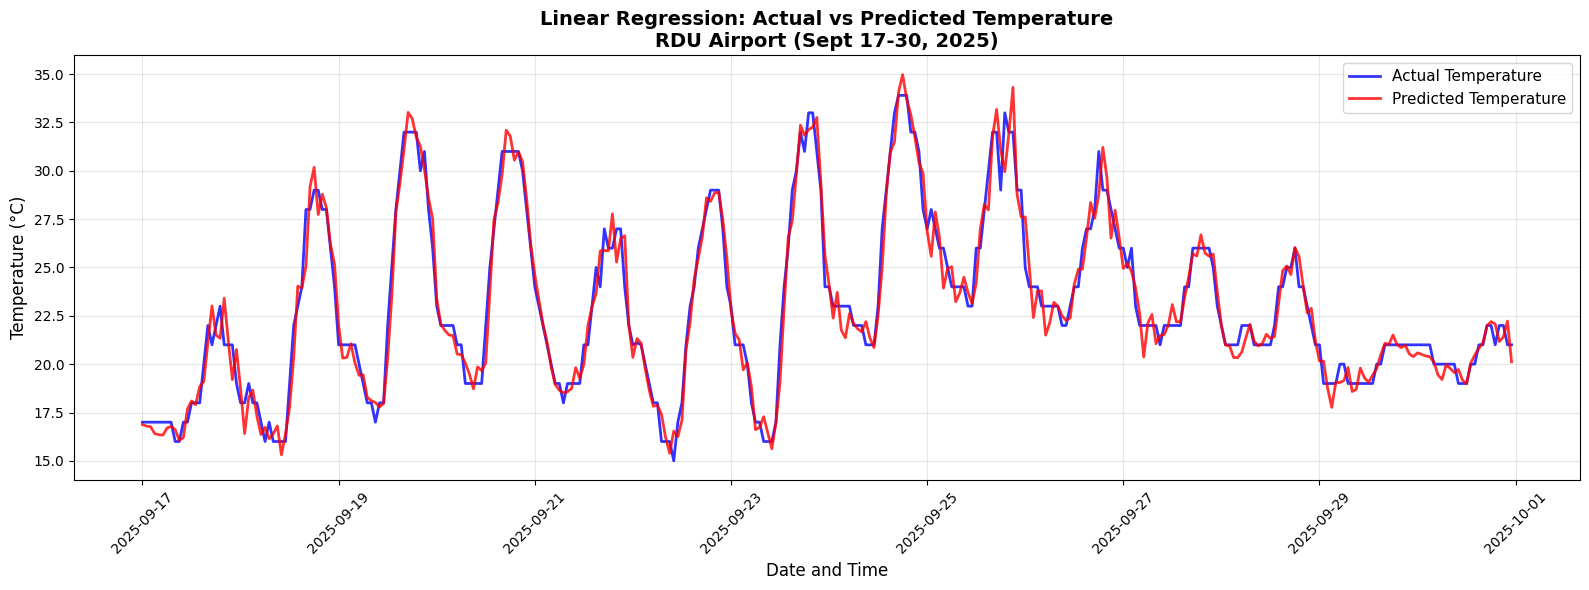

 - Time series plot created


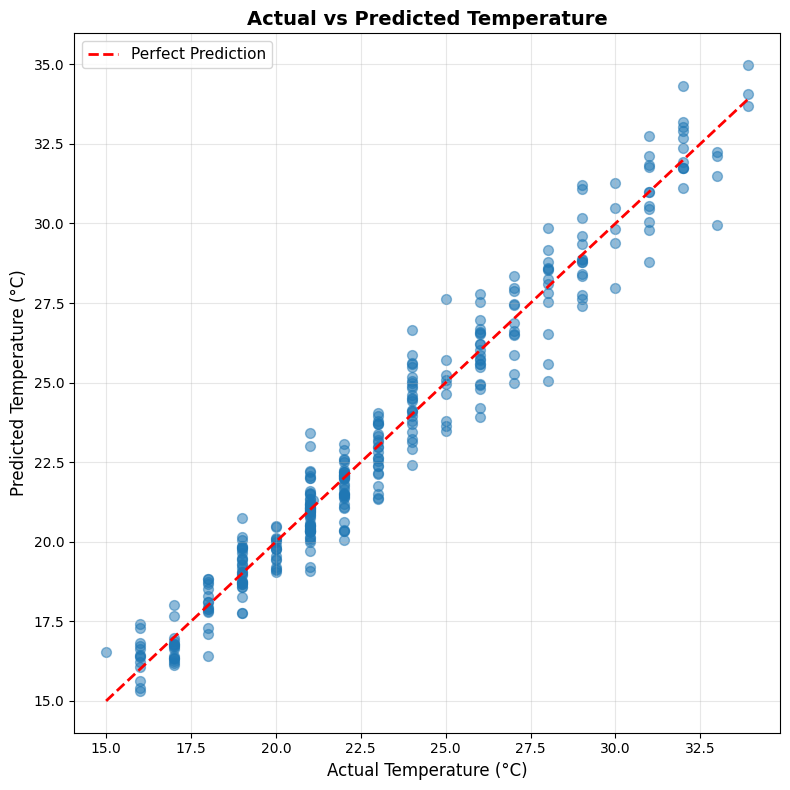

- Scatter plot created


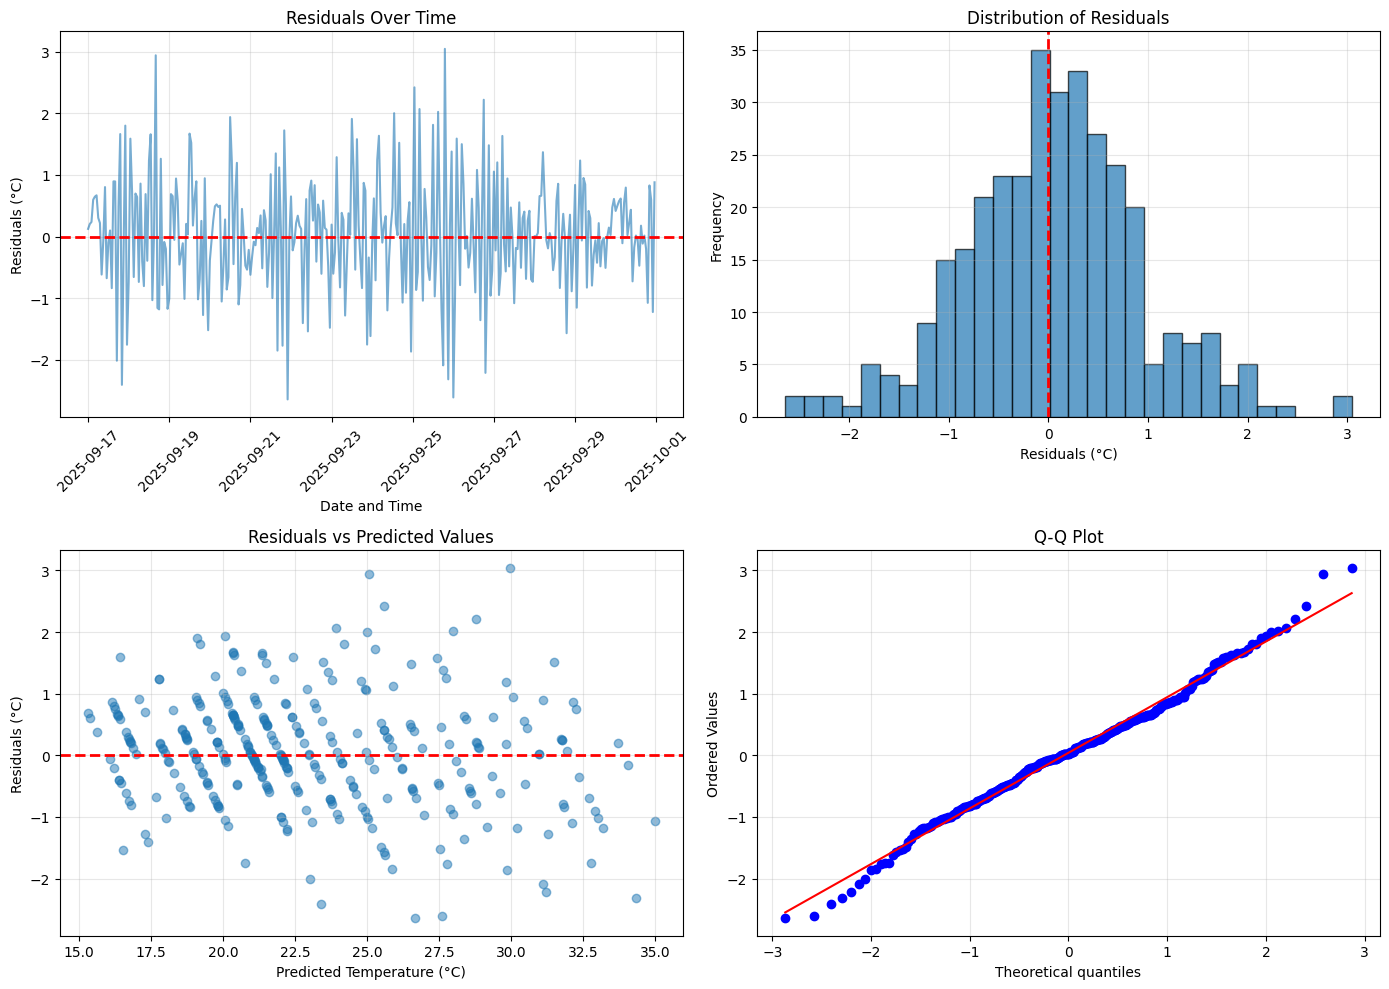

- residual analysis plots created


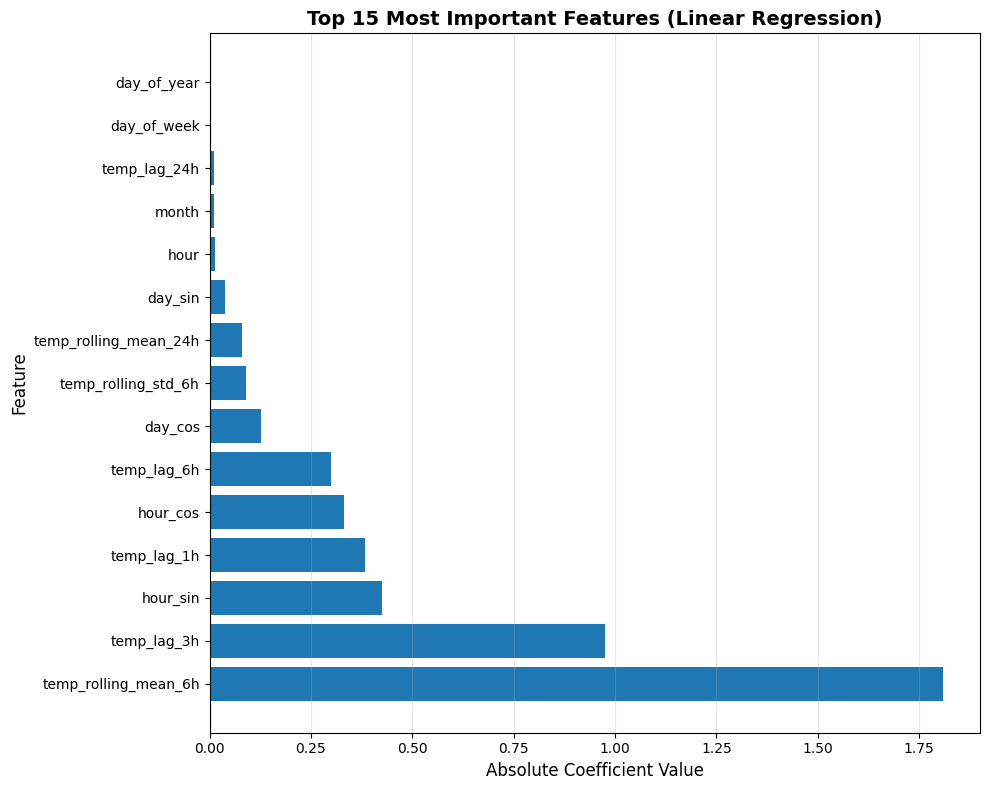

✓ Feature importance plot created


In [10]:
#Visualizations

print("CREATING VISUALIZATIONS")


# Figure 1: Time Series - Actual vs Predicted
plt.figure(figsize=(16, 6))
plt.plot(val_df['datetime'].values, y_val.values,
         label='Actual Temperature', linewidth=2, alpha=0.8, color='blue')
plt.plot(val_df['datetime'].values, y_pred_val,
         label='Predicted Temperature', linewidth=2, alpha=0.8, color='red')
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Linear Regression: Actual vs Predicted Temperature\nRDU Airport (Sept 17-30, 2025)',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(" - Time series plot created")

# Figure 2: Scatter Plot - Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred_val, alpha=0.5, s=50)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Temperature (°C)', fontsize=12)
plt.title('Actual vs Predicted Temperature', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("- Scatter plot created")

# Figure 3: Residual Analysis
residuals = y_val - y_pred_val

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals over time
axes[0, 0].plot(val_df['datetime'].values, residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Date and Time')
axes[0, 0].set_ylabel('Residuals (°C)')
axes[0, 0].set_title('Residuals Over Time')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Residual distribution
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals (°C)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].grid(True, alpha=0.3)

# Residuals vs Predicted
axes[1, 0].scatter(y_pred_val, residuals, alpha=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Temperature (°C)')
axes[1, 0].set_ylabel('Residuals (°C)')
axes[1, 0].set_title('Residuals vs Predicted Values')
axes[1, 0].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("- residual analysis plots created")

# Figure 4: Feature Importance
plt.figure(figsize=(10, 8))
top_features = coef_df.head(15)  # Top 15 features
plt.barh(range(len(top_features)), top_features['Coefficient'].abs())
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Most Important Features (Linear Regression)',
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("✓ Feature importance plot created")


ERROR ANALYSIS

Worst 5 predictions:
           datetime  actual  predicted     error
2025-09-25 19:00:00    33.0  29.954108  3.045892
2025-09-18 16:00:00    28.0  25.058844  2.941156
2025-09-21 22:00:00    24.0  26.644285 -2.644285
2025-09-26 00:00:00    25.0  27.612531 -2.612531
2025-09-25 01:00:00    28.0  25.579017  2.420983

Best 5 predictions:
           datetime  actual  predicted     error
2025-09-28 01:00:00    21.0  20.998605  0.001395
2025-09-28 00:00:00    22.0  21.993809  0.006191
2025-09-26 08:00:00    23.0  22.991400  0.008600
2025-09-29 19:00:00    21.0  21.009405 -0.009405
2025-09-30 17:00:00    22.0  21.985569  0.014431

Average absolute error by hour of day:
hour
19    1.118329
23    1.002201
12    0.905638
16    0.883861
13    0.853353
22    0.827557
18    0.804095
15    0.722307
20    0.713822
5     0.704665
Name: abs_error, dtype: float64


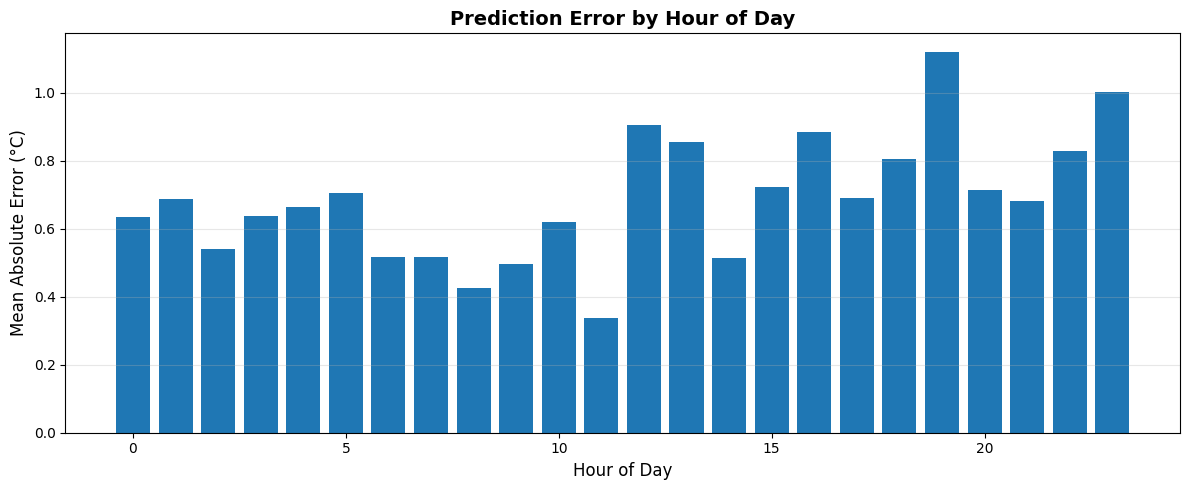

In [11]:
#Error Analysis

print("ERROR ANALYSIS")

# Where is the model making the biggest errors?
error_df = pd.DataFrame({
    'datetime': val_df['datetime'].values,
    'actual': y_val.values,
    'predicted': y_pred_val,
    'error': residuals,
    'abs_error': np.abs(residuals),
    'hour': val_df['hour'].values
})

print("\nWorst 5 predictions:")
worst = error_df.nlargest(5, 'abs_error')[['datetime', 'actual', 'predicted', 'error']]
print(worst.to_string(index=False))

print("\nBest 5 predictions:")
best = error_df.nsmallest(5, 'abs_error')[['datetime', 'actual', 'predicted', 'error']]
print(best.to_string(index=False))

# Error by hour of day
print("\nAverage absolute error by hour of day:")
hourly_error = error_df.groupby('hour')['abs_error'].mean().sort_values(ascending=False)
print(hourly_error.head(10))

plt.figure(figsize=(12, 5))
plt.bar(hourly_error.index, hourly_error.values)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Mean Absolute Error (°C)', fontsize=12)
plt.title('Prediction Error by Hour of Day', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [12]:
# Summary and Conclusions

print("SUMMARY AND CONCLUSIONS")

print(f"""
LINEAR REGRESSION MODEL SUMMARY
--------------------------------

1. MODEL PERFORMANCE:
   - Validation MSE: {val_mse:.3f}
   - Validation RMSE: {val_rmse:.3f} °C
   - Validation MAE: {val_mae:.3f} °C
   - R² Score: {val_r2:.3f}

2. COMPARISON:
   - Dominic's Ensemble MSE: 11.595
   - Linear Regression MSE: {val_mse:.3f}
   - {'- Linear regression is performing well!' if val_mse < 15 else '⚠ Room for improvement'}

3. TOP 3 MOST IMPORTANT FEATURES:
   {chr(10).join([f'   - {row["Feature"]}: {row["Coefficient"]:.4f}' for _, row in coef_df.head(3).iterrows()])}

4. KEY OBSERVATIONS:
   - Average prediction error: {val_mae:.2f}°C
   - Model captures daily temperature cycles
   - {'Good' if val_r2 > 0.8 else 'Moderate'} correlation (R² = {val_r2:.3f})

5. POTENTIAL IMPROVEMENTS:
   - Try polynomial features for non-linear relationships
   - Add more weather variables if available
   - Consider interaction terms between features
   - Experiment with different lag windows
""")


# Save predictions
predictions_df = pd.DataFrame({
    'datetime': val_df['datetime'].values,
    'actual_temperature': y_val.values,
    'predicted_temperature': y_pred_val,
    'error': residuals
})

predictions_df.to_csv('jaideep_linear_regression_predictions.csv', index=False)

# Save model summary
with open('jaideep_model_summary.txt', 'w') as f:
    f.write(f"Linear Regression Model Summary\n")
    f.write(f"================================\n\n")
    f.write(f"Validation MSE: {val_mse:.3f}\n")
    f.write(f"Validation RMSE: {val_rmse:.3f}\n")
    f.write(f"Validation MAE: {val_mae:.3f}\n")
    f.write(f"R² Score: {val_r2:.3f}\n\n")
    f.write(f"Features Used: {len(feature_columns)}\n")
    f.write(coef_df.to_string())


SUMMARY AND CONCLUSIONS

LINEAR REGRESSION MODEL SUMMARY
--------------------------------

1. MODEL PERFORMANCE:
   - Validation MSE: 0.813
   - Validation RMSE: 0.902 °C
   - Validation MAE: 0.687 °C
   - R² Score: 0.958
   
2. COMPARISON:
   - Dominic's Ensemble MSE: 11.595
   - Linear Regression MSE: 0.813
   - - Linear regression is performing well!

3. TOP 3 MOST IMPORTANT FEATURES:
      - temp_rolling_mean_6h: 1.8096
   - temp_lag_3h: -0.9750
   - hour_sin: -0.4254

4. KEY OBSERVATIONS:
   - Average prediction error: 0.69°C
   - Model captures daily temperature cycles
   - Good correlation (R² = 0.958)
   
5. POTENTIAL IMPROVEMENTS:
   - Try polynomial features for non-linear relationships
   - Add more weather variables if available
   - Consider interaction terms between features
   - Experiment with different lag windows

